In [2]:
# Accessing My Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive

/content/drive


DATA COLLECTION

In [4]:
import nltk
import string
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import string
import torch
import pickle
import warnings
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
#warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
gpath = 'My Drive/kaggle/'
data = pd.read_csv(gpath + 'sampleSubmission.csv', delimiter='\t')
train_data = pd.read_csv(gpath + 'train.tsv', delimiter='\t')
test_data = pd.read_csv(gpath + 'test.tsv', delimiter='\t')

In [6]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


The below function will lematize the input data.It is a part of pre processing the code

In [8]:
def pre_processing(data):
    def lemmatize_with_pos_tag(sentence):
        tokenized_sentence = TextBlob(sentence)
        tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
        words_and_tags = [(word, tag_dict.get(pos[0], 'n')) for word, pos in tokenized_sentence.tags]
        lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
        return " ".join(lemmatized_list)
    data = data.lower()
    data = lemmatize_with_pos_tag(data)
    return data

In [9]:
def cleaner(data):
  sentence = []
  for i in range(len(data)):
    sentence.append(pre_processing(data['Phrase'][i]))
  data['cleaned_phrase'] = sentence
  return data

In [10]:
test_data = cleaner(test_data)

In [11]:
train_data = cleaner(train_data)

In [12]:
test_data['Phrase'][15]

"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."

In [13]:
test_data['cleaned_phrase'][15]

"kidman be really the only thing that 's worth watch in birthday girl a film by the stage-trained jez butterworth -lrb- mojo -rrb- that serve as yet another example of the sad decline of british comedy in the post-full monty world"

In [14]:
train_data.to_csv(gpath + 'cleaned_train.csv')
test_data.to_csv(gpath + 'cleaned_test.csv')

In [15]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,cleaned_phrase
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrate the adage tha...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrate the adage tha...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


The below class will tokenize the data by removing html tags and split them to individual words and also remove stop words


In [16]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

We will build the model using Naive Bayes.In the fir function we will find for each class the number of examples in it and the log probability(prior).
We will use laplace smoothing function to get rid of the problem of a word in our vocabulary is in one class but not in other.Finally we will use predict function to predict sentiment from text data,we will use class priors and vocabulary



In [17]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [18]:
X = train_data['cleaned_phrase'].values
y = train_data['Sentiment'].values

  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=RANDOM_SEED)

In [19]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

In [20]:
y_hat = MNB.predict(X_test)


In [23]:
accuracy_score(y_test, y_hat)

0.5844226579520697

In [24]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.55      0.11      0.19      1416
           1       0.45      0.65      0.53      5527
           2       0.78      0.61      0.69     15639
           3       0.46      0.69      0.55      6707
           4       0.48      0.13      0.20      1923

    accuracy                           0.58     31212
   macro avg       0.54      0.44      0.43     31212
weighted avg       0.62      0.58      0.58     31212



In [25]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

array([[ 158, 1078,  100,   80,    0],
       [  94, 3591, 1220,  612,   10],
       [  33, 2671, 9593, 3273,   69],
       [   3,  547, 1313, 4649,  195],
       [   0,   70,   90, 1513,  250]])

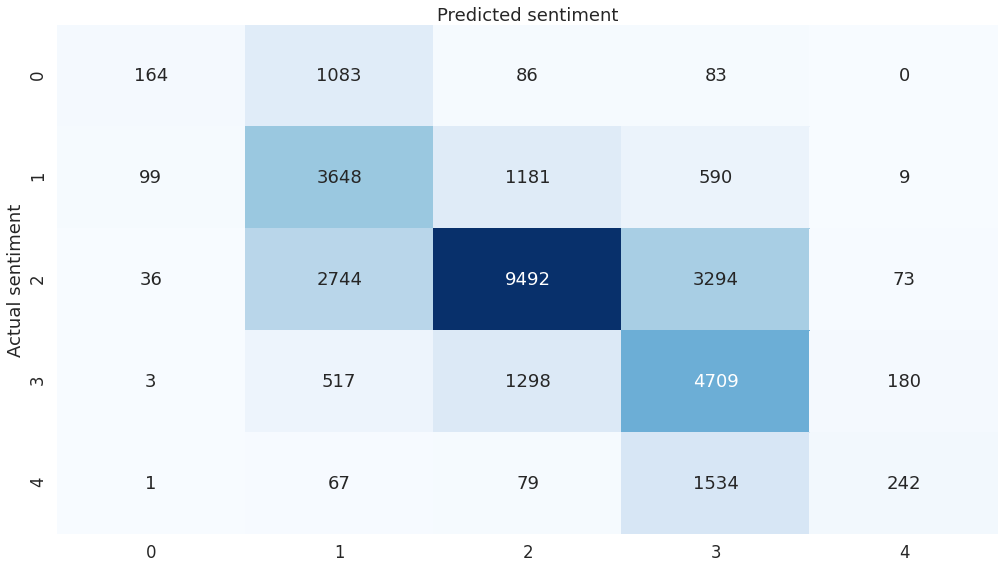

In [ ]:
class_names = ["0", "1","2","3","4"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');